## Estimating Trial Conversion Rates

### I. Exploratory Analysis

Our goal is to estimate the "eventual conversion rate"--the percent of users who start a trial who end up subscribing--for a given cohort. A cohort is defined as a group of users who started a trial on the same date. Let's take a look at our dataset.

In [910]:
#!/usr/bin/env python2

import pandas as pd
import numpy as np
import datetime


# Read in the data 

data = pd.read_csv('/Users/mgiangreco/Desktop/Strategy_Data_Set.csv')

data.head()

,id,trial_date,trial_hour,day_of_week,trial_country,subscription_date,sub_hour_start
0,51809381e4b03c6b86a6256f,5/1/2013,0,Wednesday,United States,5/14/2013,23.0
1,518093ade4b00cbd5d9abe26,5/1/2013,0,Wednesday,United States,NaN,NaN
2,518093d6e4b0c1fda9c05d54,5/1/2013,0,Wednesday,United States,5/15/2013,20.0
3,518093f2e4b0b0f0caf55867,5/1/2013,0,Wednesday,United States,NaN,NaN
4,518093fee4b01eeb7aec8bfc,5/1/2013,0,Wednesday,United States,NaN,NaN


In [911]:
# Convert date columns to datetime 

data['trial_date'] = pd.to_datetime(data['trial_date'])

data['subscription_date'] = pd.to_datetime(data['subscription_date'])

Note that there are no subscriptions after Oct 10th: the last subscription date comes about 5 months after the first trial. This suggests that the data may be right-censored--i.e., subscription events for these cohorts would not be recorded if they occurred after Oct 10th.

In [912]:
# Print summary statistics 

unique_users = data['id'].nunique()
cohorts = data['trial_date'].nunique()
min_trial_date = min(data['trial_date']).date()
max_trial_date = max(data['trial_date']).date()
min_sub_date = min(data['subscription_date']).date()
max_sub_date = max(data['subscription_date']).date()

print("The dataset contains %d unique users and %d unique cohorts, \
with trial dates ranging from %s to %s and \
subscription dates ranging from %s to %s.")\
% (unique_users, cohorts, min_trial_date, max_trial_date,\
   min_sub_date, max_sub_date)

The dataset contains 74890 unique users and 31 unique cohorts, with trial dates ranging from 2013-05-01 to 2013-05-31 and subscription dates ranging from 2013-05-01 to 2013-10-10.


The overwhelming majority of trial starts come from the United States.

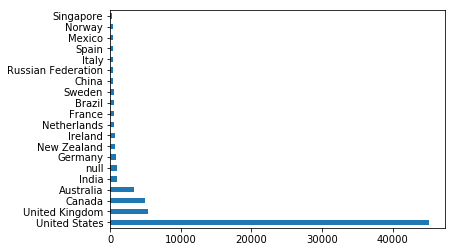

In [913]:
# Generate histogram of top 20 trial countries

data['trial_country'].value_counts()[:20].plot(kind='barh');

Trial starts are slightly lower on weekends, but that is not unexpected given the overall drop in internet usage on weekends.

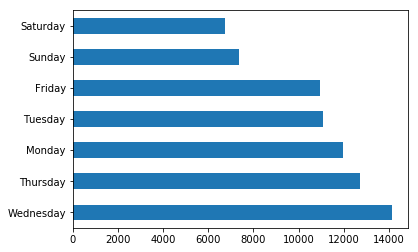

In [914]:
# Generate histogram of days of the week when trials were started

data['day_of_week'].value_counts().plot(kind='barh');

Though some cohorts are larger than others, we have >1500 users in each cohort.

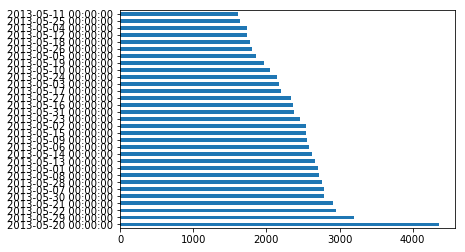

In [915]:
# Generate histogram of all trial dates

data['trial_date'].value_counts().plot(kind='barh');

### II. Kaplan-Meier Estimate of Conversion Rate

Given the possibility of censored data, one valid approach is survival analysis. This approach also generalizes well to datasets with even greater levels of censorship--for instance, very recent cohorts for which we cannot see into the future. We can plot conversion rate as a function of time using the Kaplan-Meier estimator.

In [916]:
# Add "duration" and "adopted" columns

from lifelines.utils import datetimes_to_durations

current_date = max_sub_date
start_dates = data['trial_date']
end_dates = data['subscription_date']
T, E = datetimes_to_durations(start_dates, 
                              end_dates,
                              fill_date=current_date, 
                              freq='D')

durations = pd.DataFrame(T, columns=['duration'])
event_observed = pd.DataFrame(E, columns=['subscribed'])
data = pd.concat([data, durations, event_observed], axis=1)

data.head()

,id,trial_date,trial_hour,day_of_week,trial_country,subscription_date,sub_hour_start,duration,subscribed
0,51809381e4b03c6b86a6256f,2013-05-01,0,Wednesday,United States,2013-05-14,23.0,13.0,True
1,518093ade4b00cbd5d9abe26,2013-05-01,0,Wednesday,United States,NaT,NaN,162.0,False
2,518093d6e4b0c1fda9c05d54,2013-05-01,0,Wednesday,United States,2013-05-15,20.0,14.0,True
3,518093f2e4b0b0f0caf55867,2013-05-01,0,Wednesday,United States,NaT,NaN,162.0,False
4,518093fee4b01eeb7aec8bfc,2013-05-01,0,Wednesday,United States,NaT,NaN,162.0,False


The conversion rate rises steeply around day 15 (perhaps this is a 14-day trial) and starts to level off around the 30-day mark, though it never goes completely horizontal. Because of this, we'll have to pick a more specific definition of "eventual conversion rate". For instance, the 30-day conversion rate is ~18.2%.

30-day Conversion Rate: 0.1820


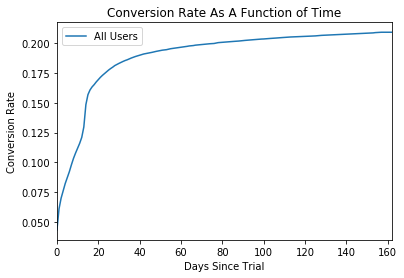

In [917]:
# Plot conversion rate as a function of time

%matplotlib inline
import lifelines
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

kmf = KaplanMeierFitter()

T = data['duration']
S = data['subscribed']

kmf.fit(T, event_observed=S,
       label='All Users')
(1-kmf.survival_function_).plot()

plt.ylabel('Conversion Rate')
plt.xlabel('Days Since Trial')
plt.title("Conversion Rate As A Function of Time");

actual = (1-kmf.survival_function_)

print ('30-day Conversion Rate: %.4f' % (actual.iloc[29]))

For users who subscribed, the average number of days from trial to subscription is ~15 (with a large standard deviation of 23). 

In [918]:
# Generate summary statistics for duration, for users who subscribed

data['duration'][data['subscribed']==True].describe()                                                    

count    15571.000000
mean        15.077002
std         23.359249
min          0.000000
25%          1.000000
50%          9.000000
75%         15.000000
max        157.000000
Name: duration, dtype: float64

Given that most trials come from the U.S., it might be interesting to compare U.S. trials against non-U.S. trials. Indeed, trials originating in the U.S. appear to have higher conversion rates.

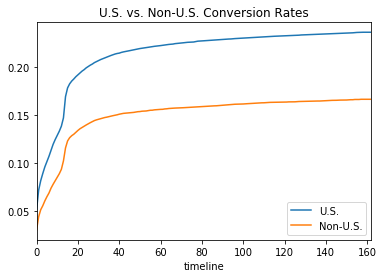

In [919]:
# Plot U.S. vs. Non-U.S. Conversion Rates

ax = plt.subplot(111)

usa = (data['trial_country'] == "United States")

kmf.fit(T[usa], event_observed=S[usa], label='U.S.')
(1-kmf.survival_function_).plot(ax=ax)
kmf.fit(T[~usa], event_observed=S[~usa], label='Non-U.S.')
(1-kmf.survival_function_).plot(ax=ax)

plt.title("U.S. vs. Non-U.S. Conversion Rates");

### III. Cox Regression

We can test for the impact of 'trial_country' and 'day_of_week' in a Cox regression. 

In [920]:
# Prepare data for regression

data.set_index('trial_date', inplace=True) # Set trial_date to index

data.drop(['id', 
           'trial_hour', 
           'sub_hour_start'], 
          axis=1, inplace=True) # drop id, trial_hour, and sub_hour

dow = pd.get_dummies(data['day_of_week']) # one hot encode day of week

data = pd.concat([data, dow], axis=1)

data['USA'] = (data['trial_country']=="United States") 

data.drop(['trial_country', 'day_of_week'], axis=1, inplace=True)

data.sample(5)

,subscription_date,duration,subscribed,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,USA
trial_date,,,,,,,,,,,
2013-05-21,NaT,142.0,False,0,0,0,0,0,1,0,False
2013-05-26,NaT,137.0,False,0,0,0,1,0,0,0,True
2013-05-24,2013-05-24,0.0,True,1,0,0,0,0,0,0,True
2013-05-22,NaT,141.0,False,0,0,0,0,0,0,1,True
2013-05-07,NaT,156.0,False,0,0,0,0,0,1,0,True


The only significant covariate is 'USA'. Day of week has no discernable impact on conversion rate, so we can drop the day of week columns. We can also show that the USA variable conforms to the proportional hazards assumption--i.e., the hazard functions of the U.S. group and the non-U.S. group are proportional over time--a key assumption of this particular model.

In [921]:
# Fit Cox regression model

from lifelines import CoxPHFitter

cph = CoxPHFitter()
cph.fit(data.iloc[:,1:], duration_col='duration', event_col='subscribed')

cph.print_summary()

n=74891, number of events=15571

              coef  exp(coef)    se(coef)       z      p   lower 0.95  upper 0.95     
Friday    -43.6749     0.0000 160233.3607 -0.0003 0.9998 -314164.3407 314076.9910     
Monday    -43.8309     0.0000 160233.3607 -0.0003 0.9998 -314164.4968 314076.8349     
Saturday  -43.7236     0.0000 160233.3607 -0.0003 0.9998 -314164.3894 314076.9423     
Sunday    -43.7038     0.0000 160233.3607 -0.0003 0.9998 -314164.3696 314076.9620     
Thursday  -43.6803     0.0000 160233.3607 -0.0003 0.9998 -314164.3461 314076.9856     
Tuesday   -43.7098     0.0000 160233.3607 -0.0003 0.9998 -314164.3757 314076.9560     
Wednesday -43.7232     0.0000 160233.3607 -0.0003 0.9998 -314164.3890 314076.9427     
USA         0.3889     1.4753      0.0172 22.5638 0.0000       0.3551      0.4227  ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 

Concordance = 0.552


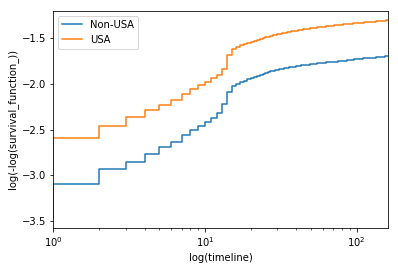

In [922]:
# Check the proportional hazards assumption of USA variable 

usa_0 = data.loc[data['USA'] == False]
usa_1 = data.loc[data['USA'] == True]

kmf0 = KaplanMeierFitter()
kmf0.fit(usa_0['duration'], event_observed=usa_0['subscribed'])

kmf1 = KaplanMeierFitter()
kmf1.fit(usa_1['duration'], event_observed=usa_1['subscribed'])

fig, axes = plt.subplots()
kmf0.plot_loglogs(ax=axes)
kmf1.plot_loglogs(ax=axes)

axes.legend(['Non-USA', 'USA'])

plt.show()

In [923]:
# Drop all day of week columns

data.drop(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 
           'Friday', 'Saturday', 'Sunday'], axis=1, inplace=True)

data.head()

,subscription_date,duration,subscribed,USA
trial_date,,,,
2013-05-01,2013-05-14,13.0,True,True
2013-05-01,NaT,162.0,False,True
2013-05-01,2013-05-15,14.0,True,True
2013-05-01,NaT,162.0,False,True
2013-05-01,NaT,162.0,False,True


### IV. Inter-Cohort Comparison

We want to know if the cohorts are performing differently from one another. Let's compare the conversion rate curve for the May 31 cohort to the conversion rate curve for all other cohorts.

In [924]:
# Generate KM_estimate of conversion rate for May 31 cohort 

cohort = datetime.datetime(2013, 5, 31)

cohort_df = data.ix[(data.index == cohort)]

kmf_may31 = KaplanMeierFitter()

kmf_may31.fit(cohort_df['duration'], 
         event_observed=cohort_df['subscribed'])

may31 = (1-kmf_may31.survival_function_)

In [925]:
# Generate KM_estimate of conversion rate for all other cohorts

rest_df = data.ix[(data.index != cohort)]

kmf_non_may31 = KaplanMeierFitter()

kmf_non_may31.fit(rest_df['duration'], 
         event_observed=rest_df['subscribed'])

non_may31 = (1-kmf_non_may31.survival_function_)

We are unable to conclude that the difference between the two curves is statistically significant. Intuitively, it makes sense that two cohorts would not have different conversion rates just because trial dates started on different days. In light of this, it might be worth exploring alternative methods of creating cohorts that are more likely to expose true differences--for instance, creating cohorts based on marketing channels.

In [926]:
from lifelines.statistics import logrank_test

results = logrank_test(cohort_df['duration'], rest_df['duration'], 
                        event_observed_A=cohort_df['subscribed'], 
                        event_observed_B=rest_df['subscribed'])
results.print_summary()

Results
   df: 1
   alpha: 0.95
   t 0: -1
   test: logrank
   null distribution: chi squared

   __ p-value ___|__ test statistic __|____ test result ____|__ is significant __
         0.60909 |              0.262 |  Cannot Reject Null |       False       


### V. Predicting Future Conversion Rates

Given what we know about conversion rates generally, we'd like to forecast 30-day conversion rates for cohorts for which we have limited information. One way to do this is via a sliding window approach, whereby we fit a model to the past data and use that fitted model to forecast the future. We can demonstrate this approach by pretending that the current date is June 1, and we would like to predict the 30-day conversion rate for the May 31 cohort. On the first day of our window, we have only one day of data for the May 31 cohort. As we move forward in time, the estimates become more accurate, and the error between the predicted 30-day conversion rate and the actual 30-day conversion rate decreases.

In [927]:
# Use a sliding window to make 30-day predictions for May 31 cohort 
# and score against 'actual' 30-day conversion rate

daterange = pd.date_range(start=datetime.datetime(2013,6,1), 
                          end=datetime.datetime(2013,6,30), 
                          freq='D')

day = 29

for d in daterange:
    
    # Create training dataset
    
    train_df = data.reset_index()
    
    train_df = train_df[['trial_date', 'subscription_date', 'USA']]
    
    start_dates = train_df['trial_date']
    end_dates = train_df['subscription_date']
    T, E = datetimes_to_durations(start_dates, 
                              end_dates,
                              fill_date=d, 
                              freq='D')

    durations = pd.DataFrame(T, columns=['duration'])
    event_observed = pd.DataFrame(E, columns=['subscribed'])
    train_df = pd.concat([train_df, durations, event_observed], 
                         axis=1)
    
    train_df.set_index('trial_date', inplace=True) # Set trial_date to index

    train_df = train_df.ix[((train_df['subscription_date'] < d) | \
                            (train_df['subscribed']==False)) \
                       & (train_df.index < d)]

    cph.fit(train_df.iloc[:,1:], duration_col='duration', 
            event_col='subscribed')

    pred_df = train_df.ix[((train_df['subscription_date'] < d) | \
                           (train_df['subscribed']==False)) \
                      & (train_df.index==cohort)]

    preds = (1-cph.predict_survival_function(pred_df)).mean(axis=1)
    
    pred = preds.iloc[day] # prediction for day 30
    
    error = abs(pred - may31.iloc[day]) / may31.iloc[day]

    print ('Prediction: %.3f, Actual: %.3f, Absolute Error: %.3f' \
           % (pred, may31.iloc[day], error))

Prediction: 0.171, Actual: 0.184, Absolute Error: 0.073
Prediction: 0.170, Actual: 0.184, Absolute Error: 0.076
Prediction: 0.170, Actual: 0.184, Absolute Error: 0.074
Prediction: 0.172, Actual: 0.184, Absolute Error: 0.063
Prediction: 0.174, Actual: 0.184, Absolute Error: 0.054
Prediction: 0.175, Actual: 0.184, Absolute Error: 0.046
Prediction: 0.176, Actual: 0.184, Absolute Error: 0.042
Prediction: 0.177, Actual: 0.184, Absolute Error: 0.039
Prediction: 0.176, Actual: 0.184, Absolute Error: 0.042
Prediction: 0.176, Actual: 0.184, Absolute Error: 0.043
Prediction: 0.177, Actual: 0.184, Absolute Error: 0.036
Prediction: 0.178, Actual: 0.184, Absolute Error: 0.032
Prediction: 0.178, Actual: 0.184, Absolute Error: 0.030
Prediction: 0.178, Actual: 0.184, Absolute Error: 0.030
Prediction: 0.179, Actual: 0.184, Absolute Error: 0.028
Prediction: 0.179, Actual: 0.184, Absolute Error: 0.028
Prediction: 0.179, Actual: 0.184, Absolute Error: 0.028
Prediction: 0.179, Actual: 0.184, Absolute Error

One thing to note is that we chose the 30-day conversion rate due to limitations in our data: the oldest cohort is only ~1 month old on June 1, meaning that we cannot make predictions beyond one month. If we had data for trial starts dating back to March, we could forecast a 90-day conversion rate, which would be closer to our stated goal of determining the "eventual conversion rate." With a larger dataset, we could also cross-validate our findings to see how stable the error curve is across different cohorts. Finally, we should think carefully about how our model is intended to be used by the business. If we are simply trying to determine if a cohort is better or worse than average, then it probably does not make sense to optimize for prediction error. If we are using the forecast for financial modeling, however, then prediction error may be the correct metric.